In [123]:
import numpy as np

class Value:
    def __init__(self , data , _children ={} , _operation = '' , label =''):
        self.data = data
        self._prev = set(_children)
        self._operation = _operation
        self.label = label
        self.grad = 0.0 # Initially 0
        self._backward = lambda: None 
        
    def __repr__(self):
        return f"The Value is : {self.data}"
    
    def __add__ (self, other):
        out = Value(self.data + other.data , (self, other) , '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        
        out._backward = _backward 
            
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data , (self, other) ,'*') 
        
        def _backward() : 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def tanh(self):
        t = np.tanh(self.data)
        out = Value (t, (self,) , 'tanh')
        
        def _backward() : 
            self.grad = (1- t**2)*out.grad
        
        out._backward = _backward
        
        return out 
        
    
# _children and _operation instroduced here to maintain expression graphs
# +- is to account for multiple contributions and no overwriting of grads

In [108]:
a = Value(2.0 , label = 'a')
b = Value(-3.0, label = 'b')
c = Value(8.0,  label = 'c')
e = a*b ; e.label= 'e'
d = e + c ; d.label ='d'
f = Value(-2.0 , label = 'f')

L = f*d ; L.label = 'L'

In [109]:
# We want to visualise the expressions
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad%.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._operation:
            # if this value is a result of some operation, create an operation node for it
            dot.node(name =  uid + n._operation, label = n._operation)
            # and connect this node to it
            dot.edge(uid + n._operation , uid)

    for n1, n2 in edges:
        # connect n1 to the operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot

# Why can't we change the name ? It doesn't work if we do!

In [110]:
# Doing backprop manually :
L.grad = 1
d.grad = L.grad * f.data
f.grad = L.grad * d.data
e.grad = d.grad
c.grad = d.grad 
b.grad = a.data * e.grad 
a.grad = b.data * e.grad

# Things to observe are that for the addition operation the same grad is propoated to the nodes ; for the binary
# multiplaction, the data of the other is multiplied to the grad of the forward step.

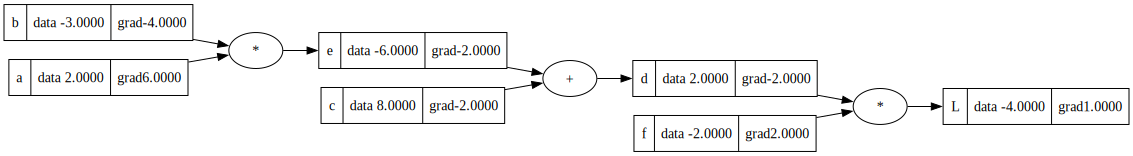

In [111]:
draw_dot(L) # Shows Forward and Bakward Propogation

In [112]:
# Creating simple dense neuron with tanh activation manually

In [118]:
w1 = Value(1.0 , label = 'w1')
w2 = Value(2.0 , label = 'w2')
x1 = Value(0.0 , label = 'x1')
x2 = Value(3.0 , label = 'x2')

w1x1 = w1*x1 ; w1x1.label= 'w1x1'
w2x2 = w2*x2 ; w2x2.label= 'w2x2'

w1x1w2x2 = w1x1+w2x2 ; w1x1w2x2.label= 'w1x1+w2x2'

b = Value(-5.4 , label = 'b')

n = w1x1w2x2 + b ; n.label = 'n'

o = n.tanh() ; o.label ='o'

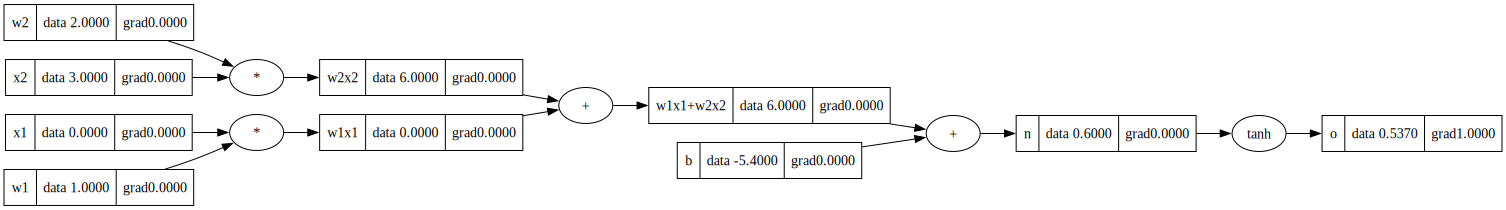

In [125]:
draw_dot(o)

In [127]:
o.grad = 1

In [128]:
o._backward()

TypeError: 'NoneType' object is not callable